<a href="https://colab.research.google.com/github/Onedory/UROP_colorize_method/blob/main/5.%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C%20%EA%B5%AC%EC%B6%95%20%EB%B0%8F%20%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ㅣ지 가

# **성능 평가 지표 선정**

**1. Perceptual Loss:**


*  이미지 간의 스타일 유사도를 평가하기 위한 지표입니다.
*   일반적으로, pretrained VGG 네트워크의 중간 계층에서 추출한 feature map 간의 차이를 통해 계산합니다.


**2. Structural Similarity Index (SSIM):**


*  이미지의 구조적 유사성을 평가하는 지표입니다.
*   SSIM은 0에서 1 사이의 값을 가지며, 1에 가까울수록 두 이미지가 구조적으로 유사하다는 것을 의미합니다.

**3. Mean Squared Error (MSE):**


*  두 이미지 간의 픽셀 값 차이를 정량화하는 지표입니다.
*  값이 작을수록 두 이미지의 유사도가 높다는 것을 의미합니다.




**4. Frechet Inception Distance (FID)::**


* 생성된 이미지의 품질을 평가하기 위한 지표입니다.
* 생성된 이미지와 실제 이미지의 Inception 네트워크에서 추출한 feature map 간의 분포 차이를 측정합니다. 값이 낮을수록 이미지 품질이 높습니다.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import vgg19, inception_v3, VGG19_Weights, Inception_V3_Weights
from torchvision import transforms
from PIL import Image

# device 설정 (GPU가 사용 가능하면 GPU 사용, 아니면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VGG 네트워크 로드 (사전 학습된 모델 사용)
vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

# Perceptual Loss 계산
class PerceptualLoss(nn.Module):
    def __init__(self, pretrained_model, layers=[0, 5, 10, 19, 28]):
        super(PerceptualLoss, self).__init__()
        self.layers = layers
        self.model = nn.Sequential(*list(pretrained_model.children())[:max(layers)+1]).eval()

    def forward(self, img1, img2):
        features_img1 = self.get_features(img1)
        features_img2 = self.get_features(img2)
        loss = sum([F.mse_loss(f1, f2) for f1, f2 in zip(features_img1, features_img2)])
        return loss

    def get_features(self, x):
        features = []
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in self.layers:
                features.append(x)
        return features

# SSIM 계산
def calculate_ssim(img1, img2):
    img1_np = img1.cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.cpu().numpy().transpose(1, 2, 0)
    data_range = max(img1_np.max(), img2_np.max()) - min(img1_np.min(), img2_np.min())
    return ssim(img1_np, img2_np, win_size=7, channel_axis=2, data_range=data_range)

# MSE 계산
def calculate_mse(img1, img2):
    return F.mse_loss(img1, img2).item()

# FID 계산
def calculate_fid(img1, img2):
    model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False).to(device)
    model.fc = nn.Identity()  # remove the last layer
    model.eval()

    def get_activations(img):
        img = F.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
        return model(img)

    act1 = get_activations(img1).detach().cpu().numpy()
    act2 = get_activations(img2).detach().cpu().numpy()

    # Check if activations are valid
    if act1.size == 0 or act2.size == 0:
        print("Warning: Activations are empty. Skipping FID calculation.")
        return None

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Ensure sigma1 and sigma2 are square matrices and valid
    if sigma1.shape != sigma2.shape or sigma1.ndim != 2 or sigma2.ndim != 2 or sigma1.shape[0] != sigma1.shape[1]:
        print("Warning: sigma matrices are not valid. Skipping FID calculation.")
        return None

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0).to(device)

# 성능 평가 지표 계산
def evaluate_image_metrics(gen_image_path, ref_image_path):
    gen_image = preprocess_image(gen_image_path)
    ref_image = preprocess_image(ref_image_path)

    perceptual_loss_fn = PerceptualLoss(vgg).to(device)
    perceptual_loss = perceptual_loss_fn(gen_image, ref_image).item()
    ssim_value = calculate_ssim(gen_image.squeeze(0), ref_image.squeeze(0))
    mse_value = calculate_mse(gen_image, ref_image)
    fid_value = calculate_fid(gen_image, ref_image)

    return {
        'Perceptual Loss': perceptual_loss,
        'SSIM': ssim_value,
        'MSE': mse_value,
        'FID': fid_value if fid_value is not None else "Invalid"
    }

# 평가 지표 계산 실행
generated_image_path = '/content/drive/MyDrive/UROP/output_optimize.png'  # 생성된 이미지 경로
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'  # 참조 이미지 경로

metrics = evaluate_image_metrics(generated_image_path, reference_image_path)
print(f"Evaluation Metrics: {metrics}")


Evaluation Metrics: {'Perceptual Loss': 12.404258728027344, 'SSIM': 0.09352448, 'MSE': 0.06344151496887207, 'FID': 'Invalid'}


색깔 차이 계산SSIM


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


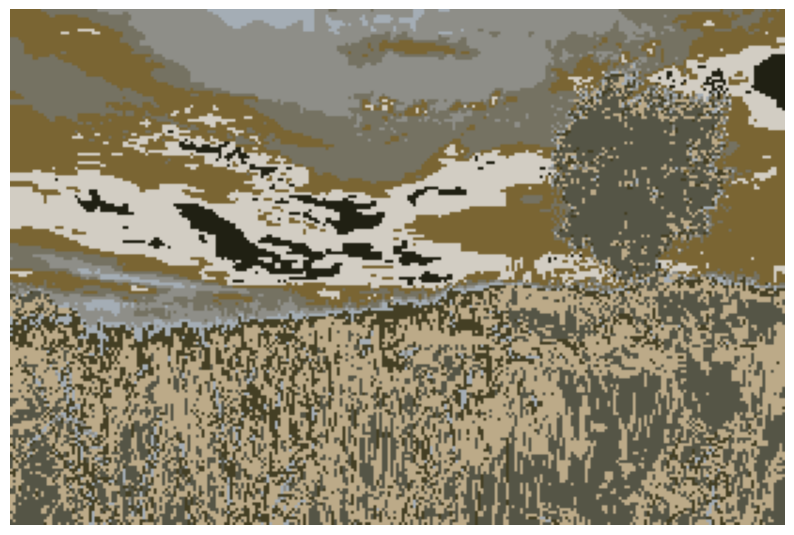

Colorized image saved to /content/drive/MyDrive/UROP/fianl_output.png
Mean Color Difference (ΔE): 29.512208822795973


In [ ]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 이미지 경로 설정
gray_image_path = '/content/drive/MyDrive/UROP/gray2.jpeg'
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# 이미지 로드
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path)

# 이미지가 정상적으로 로드되었는지 확인
if gray_image is None:
    print(f"Error loading image from {gray_image_path}. Check the file path and ensure the image exists.")
if reference_image is None:
    print(f"Error loading image from {reference_image_path}. Check the file path and ensure the image exists.")

# 최적의 파라미터로 주요 색상을 추출하는 함수
def extract_dominant_colors(image, k=10, n_init=13):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, n_init=n_init)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# 그레이스케일 이미지를 색칠하는 함수
def colorize_image(gray_image, colors):
    h, w = gray_image.shape
    colorized_image = np.zeros((h, w, 3), dtype=np.uint8)

    # 각 픽셀에 대해 가장 가까운 색상을 찾음
    for i in range(h):
        for j in range(w):
            pixel_value = gray_image[i, j]
            color_index = int(pixel_value * (len(colors) - 1) / 255)
            colorized_image[i, j] = colors[color_index]

    return colorized_image

# 참조 이미지에서 주요 색상 추출
dominant_colors = extract_dominant_colors(reference_image, k=10, n_init=13)

# 그레이스케일 이미지를 색칠
if gray_image is not None and reference_image is not None:
    colorized_image = colorize_image(gray_image, dominant_colors)

    # matplotlib으로 표시하기 위해 BGR을 RGB로 변환
    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)

    # 색칠된 이미지 표시
    plt.figure(figsize=(10, 10))
    plt.imshow(colorized_image_rgb)
    plt.axis('off')
    plt.show()

    # 색칠된 이미지 저장
    colorized_image_path = '/content/drive/MyDrive/UROP/fianl_output.png'
    cv2.imwrite(colorized_image_path, colorized_image)
    print(f"Colorized image saved to {colorized_image_path}")

# ΔE (Delta E) 색상 차이를 계산하는 함수
def calculate_color_difference(image1, image2):
    # 이미지를 CIELAB 색 공간으로 변환
    image1_lab = rgb2lab(image1)
    image2_lab = rgb2lab(image2)

    # ΔE 계산 (두 이미지 간의 평균 ΔE 값을 반환)
    delta_e = deltaE_cie76(image1_lab, image2_lab)
    mean_delta_e = np.mean(delta_e)

    return mean_delta_e

# 이미지를 다시 로드하고 크기를 맞춘 후 BGR에서 RGB로 변환
colorized_image_bgr = cv2.imread(colorized_image_path)
reference_image_bgr = cv2.imread(reference_image_path)

# 두 이미지를 동일한 크기로 조정
reference_image_bgr_resized = cv2.resize(reference_image_bgr, (colorized_image_bgr.shape[1], colorized_image_bgr.shape[0]))

# BGR을 RGB로 변환
colorized_image_rgb = cv2.cvtColor(colorized_image_bgr, cv2.COLOR_BGR2RGB)
reference_image_rgb_resized = cv2.cvtColor(reference_image_bgr_resized, cv2.COLOR_BGR2RGB)

# 색상 차이 계산
color_difference = calculate_color_difference(colorized_image_rgb, reference_image_rgb_resized)
print(f"Mean Color Difference (ΔE): {color_difference}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


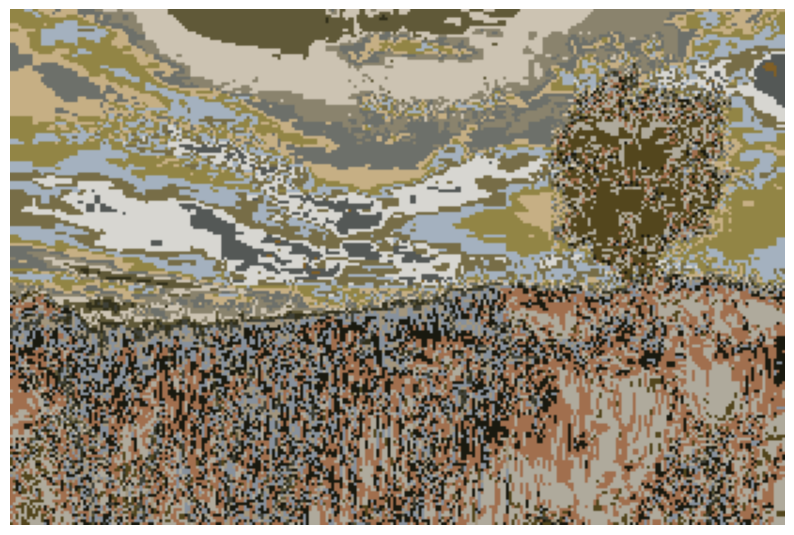

Colorized image saved to /content/drive/MyDrive/UROP/fianl_output.png
Mean Color Difference (ΔE): 32.31761886502504
Iteration 1: Adjusting k to 25, n_init to 25
New Mean Color Difference (ΔE): 32.35993955531138
Iteration 2: Adjusting k to 30, n_init to 30
New Mean Color Difference (ΔE): 33.149581474811754
Iteration 3: Adjusting k to 35, n_init to 35
New Mean Color Difference (ΔE): 32.23272740458607
Iteration 4: Adjusting k to 40, n_init to 40
New Mean Color Difference (ΔE): 33.00635336255288
Iteration 5: Adjusting k to 45, n_init to 45
New Mean Color Difference (ΔE): 32.29267750021141
Iteration 6: Adjusting k to 50, n_init to 50
New Mean Color Difference (ΔE): 32.90893486160607
Iteration 7: Adjusting k to 55, n_init to 55
New Mean Color Difference (ΔE): 33.37134356121748
Iteration 8: Adjusting k to 60, n_init to 60
New Mean Color Difference (ΔE): 32.79831106742575
Iteration 9: Adjusting k to 65, n_init to 65
New Mean Color Difference (ΔE): 33.57451003567185
Iteration 10: Adjusting k to

In [ ]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2lab, deltaE_cie76

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 이미지 경로 설정
gray_image_path = '/content/drive/MyDrive/UROP/gray2.jpeg'
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# 이미지 로드
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path)

# 이미지가 정상적으로 로드되었는지 확인
if gray_image is None:
    print(f"Error loading image from {gray_image_path}. Check the file path and ensure the image exists.")
if reference_image is None:
    print(f"Error loading image from {reference_image_path}. Check the file path and ensure the image exists.")

# 최적의 파라미터로 주요 색상을 추출하는 함수 (MiniBatchKMeans 사용)
def extract_dominant_colors(image, k=10, n_init=13):
    pixels = image.reshape(-1, 3)
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=n_init, batch_size=1000)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# 그레이스케일 이미지를 색칠하는 함수
def colorize_image(gray_image, colors):
    h, w = gray_image.shape
    colorized_image = np.zeros((h, w, 3), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            pixel_value = gray_image[i, j]
            color_index = int(pixel_value * (len(colors) - 1) / 255)
            colorized_image[i, j] = colors[color_index]

    return colorized_image

# ΔE (Delta E) 색상 차이를 계산하는 함수
def calculate_color_difference(image1, image2):
    image1_lab = rgb2lab(image1)
    image2_lab = rgb2lab(image2)

    delta_e = deltaE_cie76(image1_lab, image2_lab)
    mean_delta_e = np.mean(delta_e)

    return mean_delta_e

# 초기 파라미터 설정
k = 20
n_init = 20

# 참조 이미지에서 주요 색상 추출
dominant_colors = extract_dominant_colors(reference_image, k=k, n_init=n_init)

# 그레이스케일 이미지를 색칠
if gray_image is not None and reference_image is not None:
    colorized_image = colorize_image(gray_image, dominant_colors)

    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(colorized_image_rgb)
    plt.axis('off')
    plt.show()

    colorized_image_path = '/content/drive/MyDrive/UROP/fianl_output.png'
    cv2.imwrite(colorized_image_path, colorized_image)
    print(f"Colorized image saved to {colorized_image_path}")

colorized_image_bgr = cv2.imread(colorized_image_path)
reference_image_bgr = cv2.imread(reference_image_path)

reference_image_bgr_resized = cv2.resize(reference_image_bgr, (colorized_image_bgr.shape[1], colorized_image_bgr.shape[0]))

colorized_image_rgb = cv2.cvtColor(colorized_image_bgr, cv2.COLOR_BGR2RGB)
reference_image_rgb_resized = cv2.cvtColor(reference_image_bgr_resized, cv2.COLOR_BGR2RGB)

color_difference = calculate_color_difference(colorized_image_rgb, reference_image_rgb_resized)
print(f"Mean Color Difference (ΔE): {color_difference}")

# ΔE 값이 2 이하로 나올 때까지 반복 실행
iteration = 1
while color_difference > 2 and iteration <= 10:
    k += 5
    n_init += 5
    print(f"Iteration {iteration}: Adjusting k to {k}, n_init to {n_init}")
    dominant_colors = extract_dominant_colors(reference_image, k=k, n_init=n_init)
    colorized_image = colorize_image(gray_image, dominant_colors)
    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)
    color_difference = calculate_color_difference(colorized_image_rgb, reference_image_rgb_resized)
    print(f"New Mean Color Difference (ΔE): {color_difference}")
    iteration += 1

final_image_path = '/content/drive/MyDrive/UROP/final_output_optimized.png'
cv2.imwrite(final_image_path, colorized_image)
print(f"Optimized Colorized image saved to {final_image_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final Mean Color Difference (ΔE): 5163.482786718639


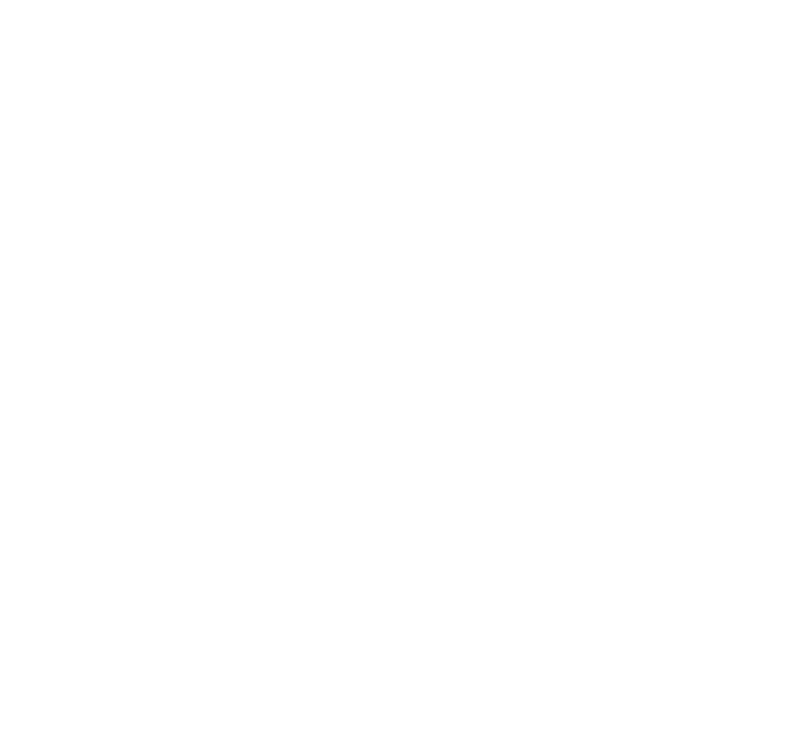

Optimized Colorized image saved to /content/drive/MyDrive/UROP/final_output_optimized.png


In [ ]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2lab, lab2rgb, deltaE_cie76
from skimage.exposure import match_histograms
from skimage.transform import resize

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 이미지 경로 설정
gray_image_path = '/content/drive/MyDrive/UROP/gray2.jpeg'
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# 이미지 로드
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path)

# 이미지가 정상적으로 로드되었는지 확인
if gray_image is None:
    print(f"Error loading image from {gray_image_path}. Check the file path and ensure the image exists.")
if reference_image is None:
    print(f"Error loading image from {reference_image_path}. Check the file path and ensure the image exists.")

# 주요 색상 추출 함수 (MiniBatchKMeans 사용)
def extract_dominant_colors(image, k=10, n_init=13):
    pixels = image.reshape(-1, 3)
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=n_init, batch_size=1000)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# 그레이스케일 이미지를 색칠하는 함수
def colorize_image(gray_image, colors):
    h, w = gray_image.shape
    colorized_image = np.zeros((h, w, 3), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            pixel_value = gray_image[i, j]
            color_index = int(pixel_value * (len(colors) - 1) / 255)
            colorized_image[i, j] = colors[color_index]

    return colorized_image

# ΔE 색상 차이 계산 함수
def calculate_color_difference(image1, image2):
    image1_lab = rgb2lab(image1)
    image2_lab = rgb2lab(image2)

    delta_e = deltaE_cie76(image1_lab, image2_lab)
    mean_delta_e = np.mean(delta_e)

    return mean_delta_e

# 히스토그램 매칭 함수 (multichannel 제거)
def apply_histogram_matching(source, reference):
    matched = match_histograms(source, reference)
    return matched

# 이미지 크기 조정 함수
def resize_images(image1, image2):
    h, w, _ = image2.shape
    resized_image1 = resize(image1, (h, w), anti_aliasing=True)
    return resized_image1, image2

# 이미지 스케일링 함수 (0-1 범위로)
def scale_image_for_display(image):
    return np.clip(image, 0, 1)

# 초기 파라미터 설정
k = 20
n_init = 20

# 참조 이미지에서 주요 색상 추출
dominant_colors = extract_dominant_colors(reference_image, k=k, n_init=n_init)

# 그레이스케일 이미지를 색칠
if gray_image is not None and reference_image is not None:
    colorized_image = colorize_image(gray_image, dominant_colors)

    # 히스토그램 매칭 적용
    reference_image_rgb = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)

    # 이미지 크기 조정
    colorized_image_rgb, reference_image_rgb = resize_images(colorized_image_rgb, reference_image_rgb)

    matched_image = apply_histogram_matching(colorized_image_rgb, reference_image_rgb)

    # 최종 ΔE 계산
    color_difference = calculate_color_difference(matched_image, reference_image_rgb)
    print(f"Final Mean Color Difference (ΔE): {color_difference}")

    # 이미지 표시 및 저장
    plt.figure(figsize=(10, 10))
    plt.imshow(scale_image_for_display(matched_image))  # 스케일링 후 표시
    plt.axis('off')
    plt.show()

    final_image_path = '/content/drive/MyDrive/UROP/final_output_optimized.png'
    plt.imsave(final_image_path, (scale_image_for_display(matched_image) * 255).astype(np.uint8))  # 스케일링 후 저장
    print(f"Optimized Colorized image saved to {final_image_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final Mean Color Difference (ΔE): 5372.344383592499


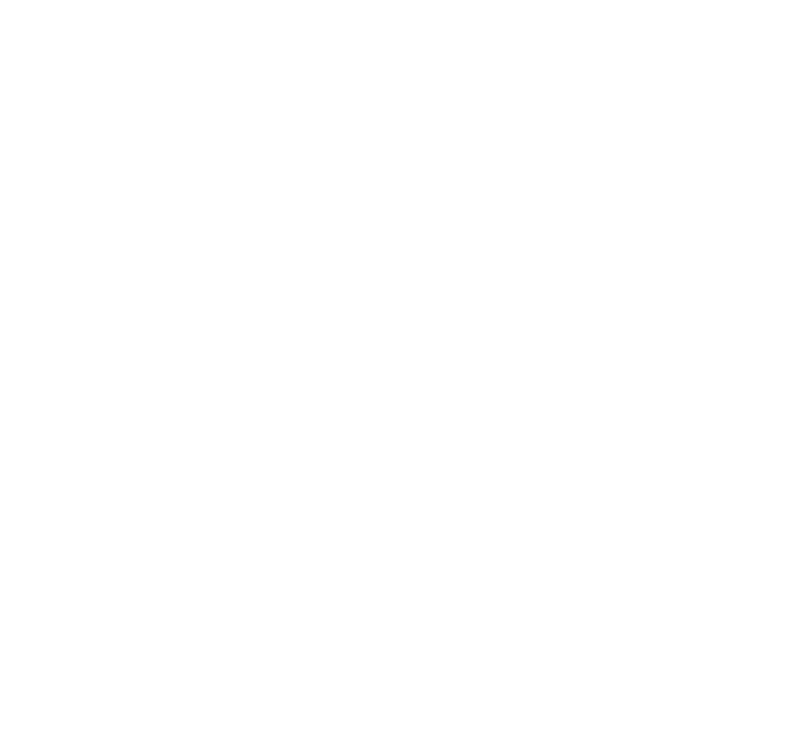

Optimized Colorized image saved to /content/drive/MyDrive/UROP/final_output_optimized.png


In [ ]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2lab, lab2rgb, deltaE_cie76, rgb2hsv, hsv2rgb
from skimage.exposure import match_histograms
from skimage.transform import resize

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 이미지 경로 설정
gray_image_path = '/content/drive/MyDrive/UROP/gray2.jpeg'
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# 이미지 로드
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path)

# 이미지가 정상적으로 로드되었는지 확인
if gray_image is None:
    print(f"Error loading image from {gray_image_path}. Check the file path and ensure the image exists.")
if reference_image is None:
    print(f"Error loading image from {reference_image_path}. Check the file path and ensure the image exists.")

# 주요 색상 추출 함수 (MiniBatchKMeans 사용)
def extract_dominant_colors(image, k=10, n_init=13):
    pixels = image.reshape(-1, 3)
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=n_init, batch_size=1000)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# 그레이스케일 이미지를 색칠하는 함수
def colorize_image(gray_image, colors):
    h, w = gray_image.shape
    colorized_image = np.zeros((h, w, 3), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            pixel_value = gray_image[i, j]
            color_index = int(pixel_value * (len(colors) - 1) / 255)
            colorized_image[i, j] = colors[color_index]

    return colorized_image

# ΔE 색상 차이 계산 함수
def calculate_color_difference(image1, image2):
    image1_lab = rgb2lab(image1)
    image2_lab = rgb2lab(image2)

    delta_e = deltaE_cie76(image1_lab, image2_lab)
    mean_delta_e = np.mean(delta_e)

    return mean_delta_e

# 히스토그램 매칭 함수
def apply_histogram_matching(source, reference):
    matched = match_histograms(source, reference)
    return matched

# 이미지 크기 조정 함수
def resize_images(image1, image2):
    h, w, _ = image2.shape
    resized_image1 = resize(image1, (h, w), anti_aliasing=True)
    return resized_image1, image2

# 이미지 스케일링 함수 (0-1 범위로)
def scale_image_for_display(image):
    return np.clip(image, 0, 1)

# 색상 보정 함수 (HSV 사용)
def adjust_color_balance(image, reference):
    image_hsv = rgb2hsv(image)
    reference_hsv = rgb2hsv(reference)

    # Reference 이미지의 Hue, Saturation 평균 값
    ref_hue = np.mean(reference_hsv[:, :, 0])
    ref_saturation = np.mean(reference_hsv[:, :, 1])

    # Image의 Hue, Saturation 값을 Reference와 맞춤
    image_hsv[:, :, 0] = image_hsv[:, :, 0] * (ref_hue / np.mean(image_hsv[:, :, 0]))
    image_hsv[:, :, 1] = image_hsv[:, :, 1] * (ref_saturation / np.mean(image_hsv[:, :, 1]))

    adjusted_image = hsv2rgb(image_hsv)
    return adjusted_image

# 초기 파라미터 설정
k = 10
n_init = 13

# 참조 이미지에서 주요 색상 추출
dominant_colors = extract_dominant_colors(reference_image, k=k, n_init=n_init)

# 그레이스케일 이미지를 색칠
if gray_image is not None and reference_image is not None:
    colorized_image = colorize_image(gray_image, dominant_colors)

    # 히스토그램 매칭 적용
    reference_image_rgb = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)

    # 이미지 크기 조정
    colorized_image_rgb, reference_image_rgb = resize_images(colorized_image_rgb, reference_image_rgb)

    matched_image = apply_histogram_matching(colorized_image_rgb, reference_image_rgb)

    # 색상 보정 적용
    adjusted_image = adjust_color_balance(matched_image, reference_image_rgb)

    # 최종 ΔE 계산
    color_difference = calculate_color_difference(adjusted_image, reference_image_rgb)
    print(f"Final Mean Color Difference (ΔE): {color_difference}")

    # 이미지 표시 및 저장
    plt.figure(figsize=(10, 10))
    plt.imshow(scale_image_for_display(adjusted_image))  # 스케일링 후 표시
    plt.axis('off')
    plt.show()

    final_image_path = '/content/drive/MyDrive/UROP/final_output_optimized.png'
    plt.imsave(final_image_path, (scale_image_for_display(adjusted_image) * 255).astype(np.uint8))  # 스케일링 후 저장
    print(f"Optimized Colorized image saved to {final_image_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final Mean Color Difference (ΔE): 5263.095782523212


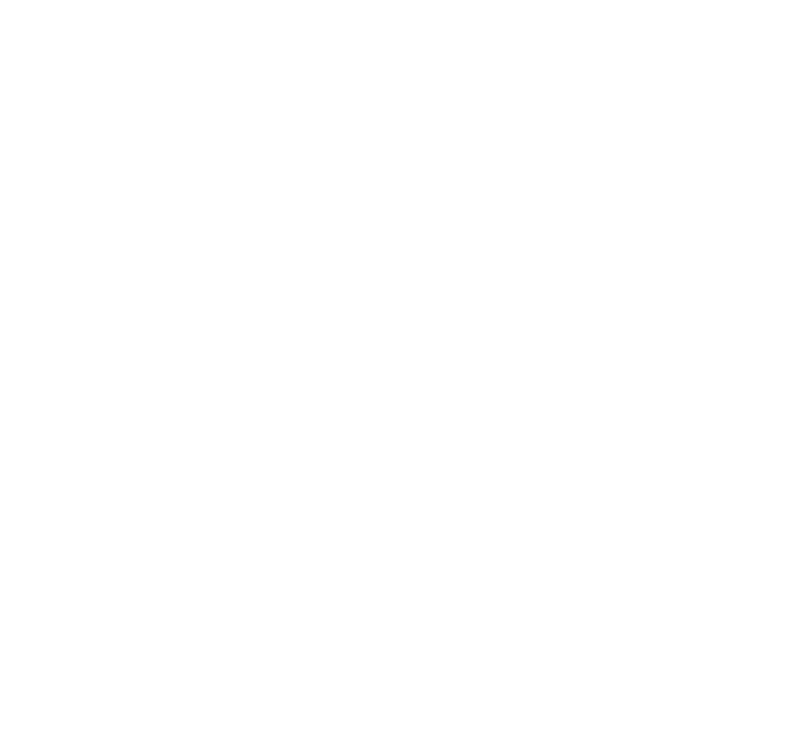

Optimized Colorized image saved to /content/drive/MyDrive/UROP/final_output_optimized.png


In [ ]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2lab, lab2rgb, deltaE_cie76
from skimage.exposure import match_histograms
from skimage.transform import resize

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 이미지 경로 설정
gray_image_path = '/content/drive/MyDrive/UROP/gray2.jpeg'
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# 이미지 로드
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path)

# 이미지가 정상적으로 로드되었는지 확인
if gray_image is None:
    print(f"Error loading image from {gray_image_path}. Check the file path and ensure the image exists.")
if reference_image is None:
    print(f"Error loading image from {reference_image_path}. Check the file path and ensure the image exists.")

# 주요 색상 추출 함수 (MiniBatchKMeans 사용)
def extract_dominant_colors(image, k=10, n_init=13):
    pixels = image.reshape(-1, 3)
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=n_init, batch_size=1000)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# 그레이스케일 이미지를 색칠하는 함수
def colorize_image(gray_image, colors):
    h, w = gray_image.shape
    colorized_image = np.zeros((h, w, 3), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            pixel_value = gray_image[i, j]
            color_index = int(pixel_value * (len(colors) - 1) / 255)
            colorized_image[i, j] = colors[color_index]

    return colorized_image

# ΔE 색상 차이 계산 함수
def calculate_color_difference(image1, image2):
    image1_lab = rgb2lab(image1)
    image2_lab = rgb2lab(image2)

    delta_e = deltaE_cie76(image1_lab, image2_lab)
    mean_delta_e = np.mean(delta_e)

    return mean_delta_e

# 히스토그램 매칭 함수
def apply_histogram_matching(source, reference):
    matched = match_histograms(source, reference)
    return matched

# 이미지 크기 조정 함수
def resize_images(image1, image2):
    h, w, _ = image2.shape
    resized_image1 = resize(image1, (h, w), anti_aliasing=True)
    return resized_image1, image2

# 이미지 스케일링 함수 (0-1 범위로)
def scale_image_for_display(image):
    return np.clip(image, 0, 1)

# 초기 파라미터 설정
k = 10
n_init = 13

# 참조 이미지에서 주요 색상 추출
dominant_colors = extract_dominant_colors(reference_image, k=k, n_init=n_init)

# 그레이스케일 이미지를 색칠
if gray_image is not None and reference_image is not None:
    colorized_image = colorize_image(gray_image, dominant_colors)

    # 히스토그램 매칭 적용
    reference_image_rgb = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)

    # 이미지 크기 조정
    colorized_image_rgb, reference_image_rgb = resize_images(colorized_image_rgb, reference_image_rgb)

    matched_image = apply_histogram_matching(colorized_image_rgb, reference_image_rgb)

    # 최종 ΔE 계산
    color_difference = calculate_color_difference(matched_image, reference_image_rgb)
    print(f"Final Mean Color Difference (ΔE): {color_difference}")

    # 이미지 표시 및 저장
    plt.figure(figsize=(10, 10))
    plt.imshow(scale_image_for_display(matched_image))  # 스케일링 후 표시
    plt.axis('off')
    plt.show()

    final_image_path = '/content/drive/MyDrive/UROP/final_output_optimized.png'
    plt.imsave(final_image_path, (scale_image_for_display(matched_image) * 255).astype(np.uint8))  # 스케일링 후 저장
    print(f"Optimized Colorized image saved to {final_image_path}")


In [ ]:
from google.colab import drive
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2lab, deltaE_cie76

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 이미지 경로 설정
gray_image_path = '/content/drive/MyDrive/UROP/gray2.jpeg'
reference_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# 이미지 로드
gray_image = cv2.imread(gray_image_path, cv2.IMREAD_GRAYSCALE)
reference_image = cv2.imread(reference_image_path)

# 이미지가 정상적으로 로드되었는지 확인
if gray_image is None:
    print(f"Error loading image from {gray_image_path}. Check the file path and ensure the image exists.")
if reference_image is None:
    print(f"Error loading image from {reference_image_path}. Check the file path and ensure the image exists.")

# 주요 색상 추출 함수 (MiniBatchKMeans 사용)
def extract_dominant_colors(image, k=10, n_init=10):
    pixels = image.reshape(-1, 3)
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=n_init, batch_size=1000)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    return colors

# ΔE 색상 차이 계산 함수
def calculate_palette_difference(palette1, palette2):
    palette1_lab = rgb2lab(palette1)
    palette2_lab = rgb2lab(palette2)

    delta_e = np.zeros((len(palette1_lab), len(palette2_lab)))

    for i in range(len(palette1_lab)):
        for j in range(len(palette2_lab)):
            delta_e[i, j] = deltaE_cie76(palette1_lab[i], palette2_lab[j])

    mean_min_delta_e = np.mean(np.min(delta_e, axis=1))
    return mean_min_delta_e

# 그레이스케일 이미지를 색칠하는 함수
def colorize_image(gray_image, colors):
    h, w = gray_image.shape
    colorized_image = np.zeros((h, w, 3), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            pixel_value = gray_image[i, j]
            color_index = int(pixel_value * (len(colors) - 1) / 255)
            colorized_image[i, j] = colors[color_index]

    return colorized_image

# 초기 파라미터 설정
k = 10
n_init = 10

# 참조 이미지에서 주요 색상 추출
dominant_colors_ref = extract_dominant_colors(reference_image, k=k, n_init=n_init)

# 그레이스케일 이미지를 색칠
if gray_image is not None and reference_image is not None:
    colorized_image = colorize_image(gray_image, dominant_colors_ref)

    # 색상 팔레트 추출
    colorized_image_rgb = cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB)
    dominant_colors_gen = extract_dominant_colors(colorized_image_rgb, k=k, n_init=n_init)

    # 팔레트 간 ΔE 계산
    palette_difference = calculate_palette_difference(dominant_colors_gen, dominant_colors_ref)
    print(f"Palette Mean Color Difference (ΔE): {palette_difference}")

    # 이미지 저장
    final_image_path = '/content/drive/MyDrive/UROP/final_output_palette.png'
    cv2.imwrite(final_image_path, colorized_image)
    print(f"Optimized Colorized image saved to {final_image_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Palette Mean Color Difference (ΔE): 1400.7309606925337
Optimized Colorized image saved to /content/drive/MyDrive/UROP/final_output_palette.png


# 성능 평가 지표 최적화

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from IPython.display import Image as display_image

# 계산을 위한 유틸리티 함수
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# VGG 네트워크와 디코더 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

# 사전 학습된 모델 불러오기
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31])  # ReLU4_1까지만 사용

# 네트워크 정의
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

# 스타일 전이 함수 정의
def adain_style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

# NST 스타일 전이 함수 (PyTorch로 수정)
def nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=200):
    content_targets = extractor.encode(content_image)
    style_targets = extractor.encode_with_intermediate(style_image)
    style_weight = 1000
    content_weight = 1

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        content_loss, style_loss = extractor(new_image, style_image)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}')

    return new_image

# 이미지 전처리 함수 정의
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)




--2024-08-21 03:09:01--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-08-21 03:09:02--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  5.25MB/s    in 2.5s  

<ipython-input-6-d0156ac0c8ed>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_image = torch.tensor(adain_output.clone().detach())


Epoch 50/200, Content Loss: 0.6949331760406494, Style Loss: 0.3470343351364136
Epoch 100/200, Content Loss: 0.6949331760406494, Style Loss: 0.3470343351364136
Epoch 150/200, Content Loss: 0.6949331760406494, Style Loss: 0.3470343351364136
Epoch 200/200, Content Loss: 0.6949331760406494, Style Loss: 0.3470343351364136


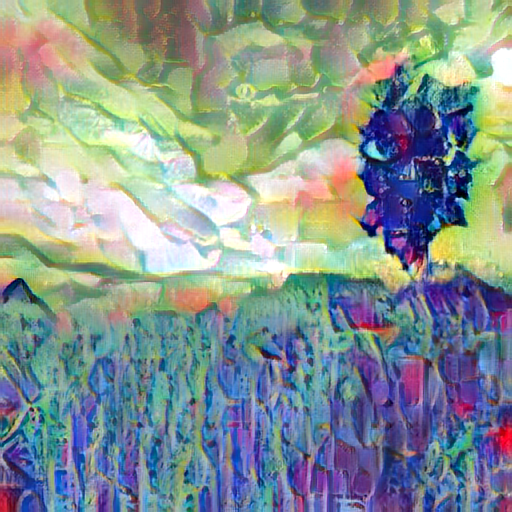

In [ ]:
# 이미지 로드 및 전처리
content_image_path = '/content/drive/MyDrive/UROP/colorized_with_ahm.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_5.png'

# Check if the file exists
import os
if not os.path.exists(style_image_path):
    print(f"Error: File not found at {style_image_path}")
else:
    content_image = load_and_preprocess_image(content_image_path)
    style_image = load_and_preprocess_image(style_image_path)

    # AdaIN 적용
    with torch.no_grad():
        adain_output = adain_style_transfer(vgg, decoder, content_image, style_image, alpha=1.0)

# NST 적용
extractor = Net(vgg, decoder).to(device)
# Remove requires_grad=True to prevent gradients from being computed for new_image
new_image = torch.tensor(adain_output.clone().detach())
optimizer = optim.Adam([new_image], lr=0.07)
final_image = nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=200)
# 최종 결과 출력
save_image(final_image, '/content/drive/MyDrive/UROP/output_optimize_style.png')
display_image('/content/drive/MyDrive/UROP/output_optimize_style.png')

평가지표구축

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

# 이미지 경로 설정
final_image_path = '/content/drive/MyDrive/UROP/output_optimize_style.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_5.png'

# 이미지를 로드하고 전처리하는 함수
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path).convert("RGB")
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.LANCZOS)
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    if transform:
        image = transform(image).unsqueeze(0)
    return image

# Perceptual Loss (VGG Loss) 계산
class PerceptualLoss(nn.Module):
    def __init__(self, pretrained_model):
        super(PerceptualLoss, self).__init__()
        self.model = nn.Sequential(*list(pretrained_model.children())[:31]).eval()

    def forward(self, img1, img2):
        features_img1 = self.model(img1)
        features_img2 = self.model(img2)
        return F.mse_loss(features_img1, features_img2)

# 이미지 전처리 함수 정의
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# 이미지 로드 및 전처리
final_image = load_image(final_image_path, transform=transform)
style_image = load_image(style_image_path, transform=transform)

# Perceptual Loss 계산
vgg = models.vgg19(pretrained=True).features
perceptual_loss_fn = PerceptualLoss(vgg).to('cuda')
final_image = final_image.to('cuda')
style_image = style_image.to('cuda')

perceptual_loss = perceptual_loss_fn(final_image, style_image).item()

# 결과 출력
print(f"Perceptual Loss: {perceptual_loss}")


Perceptual Loss: 6.735233306884766


Loss 줄이기

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

# 계산을 위한 유틸리티 함수
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# VGG 네트워크와 디코더 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

# 사전 학습된 모델 불러오기
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31])  # ReLU4_1까지만 사용

# 네트워크 정의
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

# 스타일 전이 함수 정의
def adain_style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

# NST 스타일 전이 함수 (PyTorch로 수정)
def nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, max_epochs=200, early_stopping_threshold=0.001):
    content_targets = extractor.encode(content_image)
    style_targets = extractor.encode_with_intermediate(style_image)
    style_weight = 1000
    content_weight = 1

    previous_loss = float('inf')
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        content_loss, style_loss = extractor(new_image, style_image)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()

        current_loss = total_loss.item()
        print(f'Epoch {epoch + 1}/{max_epochs}, Total Loss: {current_loss}')

        # Early stopping
        if abs(previous_loss - current_loss) < early_stopping_threshold:
            print(f"Stopping early at epoch {epoch + 1} as loss improvement is below threshold.")
            break

        previous_loss = current_loss

    return new_image


# 이미지 전처리 함수 정의
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)



# Perceptual Loss 계산을 위한 함수
def calculate_perceptual_loss(vgg, decoder, content_image, style_image, alpha):
    with torch.no_grad():
        styled_image = adain_style_transfer(vgg, decoder, content_image, style_image, alpha)
    perceptual_loss_fn = nn.MSELoss()
    content_feat = vgg(content_image)
    style_feat = vgg(styled_image)
    return perceptual_loss_fn(content_feat, style_feat)

# Alpha 값 최적화
best_alpha = None
best_loss = float('inf')

for alpha in [0.2, 0.4, 0.6, 0.8, 1.0]:
    current_loss = calculate_perceptual_loss(vgg, decoder, content_image, style_image, alpha).item()
    print(f"Alpha: {alpha}, Perceptual Loss: {current_loss}")
    if current_loss < best_loss:
        best_loss = current_loss
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Lowest Perceptual Loss: {best_loss}")

--2024-08-21 10:21:39--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-08-21 10:21:40--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  5.07MB/s    in 2.6s  

In [ ]:
# 이미지 로드 및 전처리
content_image_path = '/content/drive/MyDrive/UROP/colorized_with_ahm.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_5.png'

content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)

# 최적의 alpha 값 사용하여 AdaIN 적용
with torch.no_grad():
    adain_output = adain_style_transfer(vgg, decoder, content_image, style_image, alpha=0.2)

# NST 적용
extractor = Net(vgg, decoder).to(device)
new_image = torch.tensor(adain_output.clone().detach(), requires_grad=True) # Remove requires_grad=True
optimizer = optim.Adam([new_image], lr=0.07)

# Change the line above to:
new_image = torch.tensor(adain_output.clone().detach(), requires_grad=False) # Set requires_grad=False

final_image = nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, max_epochs=200)
save_image(final_image, '/content/drive/MyDrive/UROP/output_optimize_style.png')


<ipython-input-33-1016a604e734>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_image = torch.tensor(adain_output.clone().detach(), requires_grad=True) # Remove requires_grad=True
<ipython-input-33-1016a604e734>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_image = torch.tensor(adain_output.clone().detach(), requires_grad=False) # Set requires_grad=False


Epoch 1/200, Total Loss: 420.6027526855469
Epoch 2/200, Total Loss: 420.6027526855469
Stopping early at epoch 2 as loss improvement is below threshold.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

# 계산을 위한 유틸리티 함수
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# VGG 네트워크와 디코더 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

# 사전 학습된 모델 불러오기
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31])  # ReLU4_1까지만 사용

# 네트워크 정의
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

   # Net 클래스 내 수정
    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        # target.detach()를 사용하여 gradients 계산을 방지
        loss_c = self.calc_content_loss(g_t_feats[-1], t.detach())
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0].detach())
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i].detach())
        return loss_c, loss_s


# 스타일 전이 함수 정의
def adain_style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

# NST 스타일 전이 함수 (PyTorch로 수정)
def nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, max_epochs=200, early_stopping_threshold=0.001):
    content_targets = extractor.encode(content_image)
    style_targets = extractor.encode_with_intermediate(style_image)
    style_weight = 1000
    content_weight = 1

    previous_loss = float('inf')
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        content_loss, style_loss = extractor(new_image, style_image)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()

        current_loss = total_loss.item()
        print(f'Epoch {epoch + 1}/{max_epochs}, Total Loss: {current_loss}')

        # Early stopping
        if abs(previous_loss - current_loss) < early_stopping_threshold:
            print(f"Stopping early at epoch {epoch + 1} as loss improvement is below threshold.")
            break

        previous_loss = current_loss

    return new_image


# 이미지 전처리 함수 정의
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)



# Perceptual Loss 계산을 위한 함수
def calculate_perceptual_loss(vgg, decoder, content_image, style_image, alpha):
    with torch.no_grad():
        styled_image = adain_style_transfer(vgg, decoder, content_image, style_image, alpha)
    perceptual_loss_fn = nn.MSELoss()
    content_feat = vgg(content_image)
    style_feat = vgg(styled_image)
    return perceptual_loss_fn(content_feat, style_feat)

# Alpha 값 최적화
best_alpha = None
best_loss = float('inf')

for alpha in [0.2, 0.4, 0.6, 0.8, 1.0]:
    current_loss = calculate_perceptual_loss(vgg, decoder, content_image, style_image, alpha).item()
    print(f"Alpha: {alpha}, Perceptual Loss: {current_loss}")
    if current_loss < best_loss:
        best_loss = current_loss
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Lowest Perceptual Loss: {best_loss}")

--2024-08-21 11:30:55--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-08-21 11:30:56--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  5.54MB/s    in 2.4s  

In [ ]:
# 이미지 로드 및 전처리
content_image_path = '/content/drive/MyDrive/UROP/colorized_with_ahm.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_5.png'

content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)

with torch.no_grad():
    adain_output = adain_style_transfer(vgg, decoder, content_image, style_image, alpha=0.2)

# NST 적용
extractor = Net(vgg, decoder).to(device)
new_image = adain_output.clone().detach().requires_grad_(True)  # Set requires_grad=True properly
optimizer = optim.Adam([new_image], lr=0.07)

final_image = nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, max_epochs=200, early_stopping_threshold=0.005)  # Adjust early_stopping_threshold if necessary
save_image(final_image, '/content/drive/MyDrive/UROP/output_optimize_style.png')

Epoch 1/200, Total Loss: 420.6027526855469
Epoch 2/200, Total Loss: 1380.4219970703125
Epoch 3/200, Total Loss: 445.17108154296875
Epoch 4/200, Total Loss: 3048.65966796875
Epoch 5/200, Total Loss: 633.3970336914062
Epoch 6/200, Total Loss: 271.4238586425781
Epoch 7/200, Total Loss: 223.93295288085938
Epoch 8/200, Total Loss: 142.43310546875
Epoch 9/200, Total Loss: 102.49398040771484
Epoch 10/200, Total Loss: 100.3172836303711
Epoch 11/200, Total Loss: 73.8503189086914
Epoch 12/200, Total Loss: 71.4926986694336
Epoch 13/200, Total Loss: 68.49705505371094
Epoch 14/200, Total Loss: 56.963951110839844
Epoch 15/200, Total Loss: 53.525062561035156
Epoch 16/200, Total Loss: 51.6320915222168
Epoch 17/200, Total Loss: 45.4384651184082
Epoch 18/200, Total Loss: 41.4759407043457
Epoch 19/200, Total Loss: 40.492557525634766
Epoch 20/200, Total Loss: 37.33094024658203
Epoch 21/200, Total Loss: 33.75647735595703
Epoch 22/200, Total Loss: 32.79021453857422
Epoch 23/200, Total Loss: 31.8027973175048